# IMPORTS

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# DATAFRAME

**READ FROM CSV, CONVERT SIGNALDATE COL TO DATE AND SET AS INDEX**

In [3]:
path = "/Users/aleksandermisztal/Desktop/CLASSIFIER/image-classifier/time-series/data/AirPassengers.csv"
df = pd.read_csv(path, parse_dates=["Month"], index_col=['Month'])

In [4]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# PREPARING DATASET

**SORT BY INDEX**

In [5]:
df.sort_index(axis = 0, inplace = True)

**DROP DUPLICATES**

In [6]:
df.drop_duplicates(inplace = True)

**SET NAN TO 0**

In [7]:
df.fillna(0, inplace = True) #For entire df
# df['DataFrame Column'] = df['DataFrame Column'].fillna(0) #For column 

**DROP NULL**

In [8]:
df.dropna(inplace = True)

**GROUP BY HOUR & MEAN COLUMN**

In [9]:
# df = df.groupby(pd.Grouper(freq='H'))['dPD'].sum().to_frame()

# ACF PACF

A time series is a sequence of measurements of the same variable(s) made over time. Usually, the measurements are made at evenly spaced times — for example, monthly or yearly. The coefficient of correlation between two values in a time series is called the autocorrelation function (ACF). In other words,

>Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.

>Autocorrelation measures the relationship between a variable’s current value and its past values.

>An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.

**IMPORT**

In [10]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

**PLOT ACF & PACF**

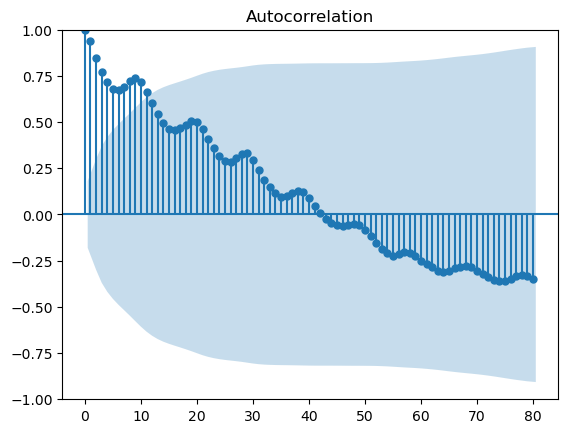

In [11]:
acf_plot = plot_acf(df['#Passengers'],lags=80)

/usr/local/Caskroom/miniconda/base/envs/img-classifier-env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


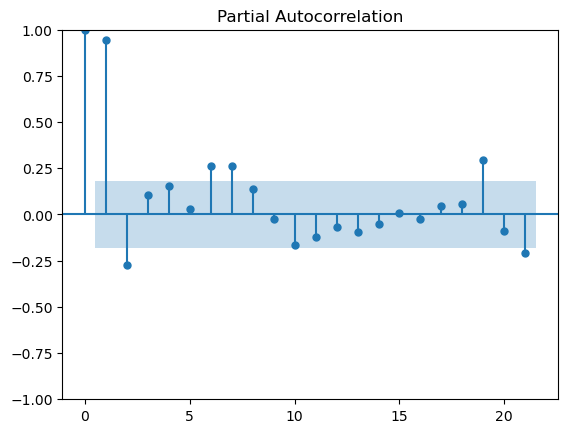

In [12]:
pacf_plot = plot_pacf(df['#Passengers'])

# DECOMPOSITION

**IMPORT**

In [13]:
from statsmodels.tsa.seasonal import STL

**CREATE & FIT STL MODEL**

In [14]:
stl = STL(df['#Passengers'],period=12)
result = stl.fit()

**ASSIGN VALUES TO VARIABLES**

In [15]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

**PLOT ORIGINAL, TREND, SEASONALITY AND RESIDUALS**

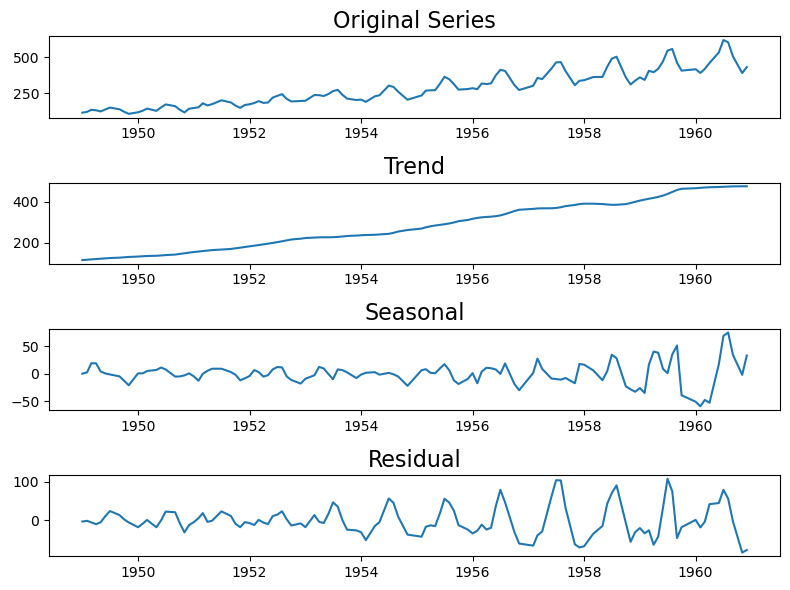

In [101]:
plt.figure(figsize=(8,6))
#---------------------------------------
plt.subplot(4,1,1)
plt.plot(df['#Passengers'][:500])
plt.title('Original Series',fontsize=16)
#---------------------------------------
plt.subplot(4,1,2)
plt.plot(trend[:500])
plt.title('Trend',fontsize=16)
#---------------------------------------
plt.subplot(4,1,3)
plt.plot(seasonal[:500])
plt.title('Seasonal',fontsize=16)
#---------------------------------------
plt.subplot(4,1,4)
plt.plot(resid[:500])
plt.title('Residual',fontsize=16)
#---------------------------------------
plt.tight_layout()

**SUM TREND AND SEASONALITY AS ESTIMATED**

In [102]:
estimated = trend + seasonal

**PLOT ESTIMATED VALUES & COMPARE TO ORIGINAL**

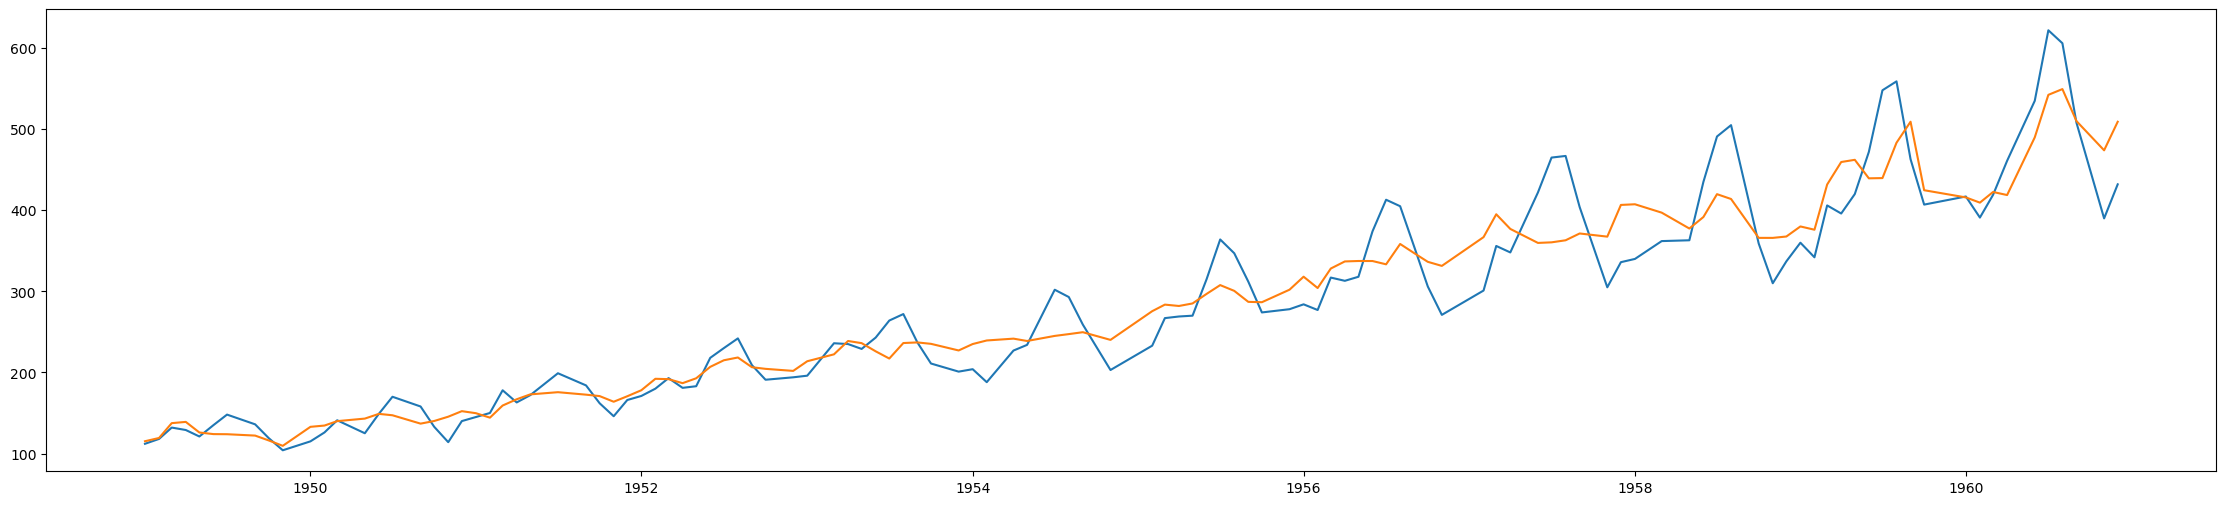

In [103]:
plt.figure(figsize=(28,6))
plt.plot(df['#Passengers'])
plt.plot(estimated)

# Anomaly Detection

In [104]:
from datetime import datetime

In [105]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower_threshold = resid_mu - 3* resid_dev
upper_threshold = resid_mu + 3* resid_dev

(-7305.0, -3653.0)

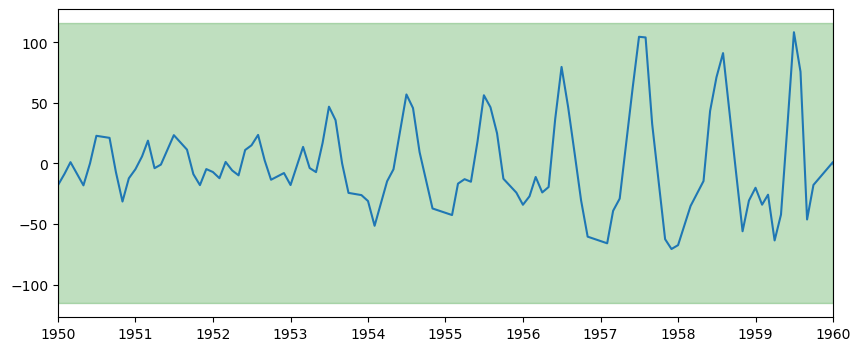

In [106]:
plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(1950,1,1), datetime(1960,1,1)], lower_threshold, upper_threshold, color='g', alpha=.25 )
plt.xlim(datetime(1950,1,1), datetime(1960,1,1))

In [107]:
anomalies = df[(resid < lower_threshold) | (resid > upper_threshold)]

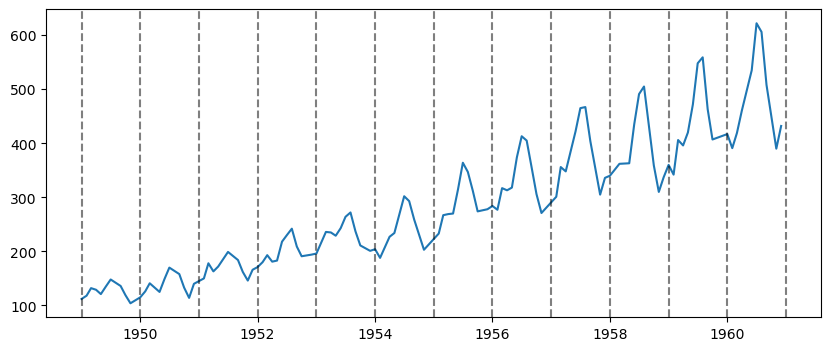

In [108]:
plt.figure(figsize = (10,4))
plt.plot(df)
for year in range (1949, 1962):
    plt.axvline(datetime(year,1,1), color='k', linestyle = '--', alpha=.5)

plt.scatter(anomalies.index, anomalies["#Passengers"], color='r', marker='D')

If there are anomalies you will see a red dot on original data

# Train/Test

In [109]:
size = len(df)
train = df[:int(size*.7)]
test = df[int(size*.7):]

# SCALING

**IMPORT**

In [110]:
from sklearn.preprocessing import MinMaxScaler

**DECLARING SCALER**

In [111]:
scaler = MinMaxScaler()

**Scaling Train And Test Sets**

In [112]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [113]:
scaled_train[:5]

array([[0.02588997],
       [0.04530744],
       [0.09061489],
       [0.08090615],
       [0.05501618]])

# Preparing Data For Model

**imports**

In [114]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [115]:
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [116]:
len(scaled_train), len(generator)

(82, 75)

In [117]:
X, y = generator[0]
print("From this set: {}".format(X.flatten()))
print("Predict this: {}".format(y))

From this set: [0.02588997 0.04530744 0.09061489 0.08090615 0.05501618 0.10032362
 0.14239482]
Predict this: [[0.10355987]]


In [118]:
X.shape, y.shape

((1, 7, 1), (1, 1))

# ML

**imports**

In [119]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

**Define model**

In [132]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss = 'mse')

In [133]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               40800     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [134]:
model.fit(generator, epochs=20)

Epoch 1/20
75/75 [==============================] - 1s 3ms/step - loss: 0.0850
Epoch 2/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0210
Epoch 3/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 5/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 6/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 7/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 8/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 9/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 10/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 11/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 12/20
75/75 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 13/20
75/75 [==============================

In [135]:
last_train_batch = scaled_train[-7:]

In [136]:
last_train_batch = last_train_batch.reshape((1,7,1))

In [137]:
pred = model.predict(last_train_batch)

1/1 [==============================] - 0s 164ms/step


In [138]:
pred = scaler.inverse_transform(pred)

In [139]:
int(pred)

358

In [146]:
result = scaler.inverse_transform(scaled_test[0].reshape((-1,1)))

In [154]:
acc = result/pred*100
print("accuracy {}%".format(round(acc[0][0],2)))

accuracy 96.98%
